In [4]:
import os
#spark imports
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
import csv

from pyspark.sql.types import *
from pyspark.sql.functions import format_number, when


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyspark.sql.functions as F
from sklearn.preprocessing import LabelEncoder

In [5]:
spark = SparkSession.builder.getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/20 20:04:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [30]:
# canalso get preprocessed data
data = pd.read_csv('pre_processed_data/2018onwards.csv')
data = data.sample(n=50000)

In [31]:
data.drop(['Date'], axis=1)
data.columns


Index(['Date', 'Block', 'Primary Type', 'Location Description', 'Arrest',
       'Beat', 'District', 'Ward', 'Community Area', 'Year', 'Latitude',
       'Longitude', 'Day', 'Month', 'WeekDay'],
      dtype='object')

# Data Visualization

In [32]:
primaryVisualizeDF = data.groupby('Primary Type').size()

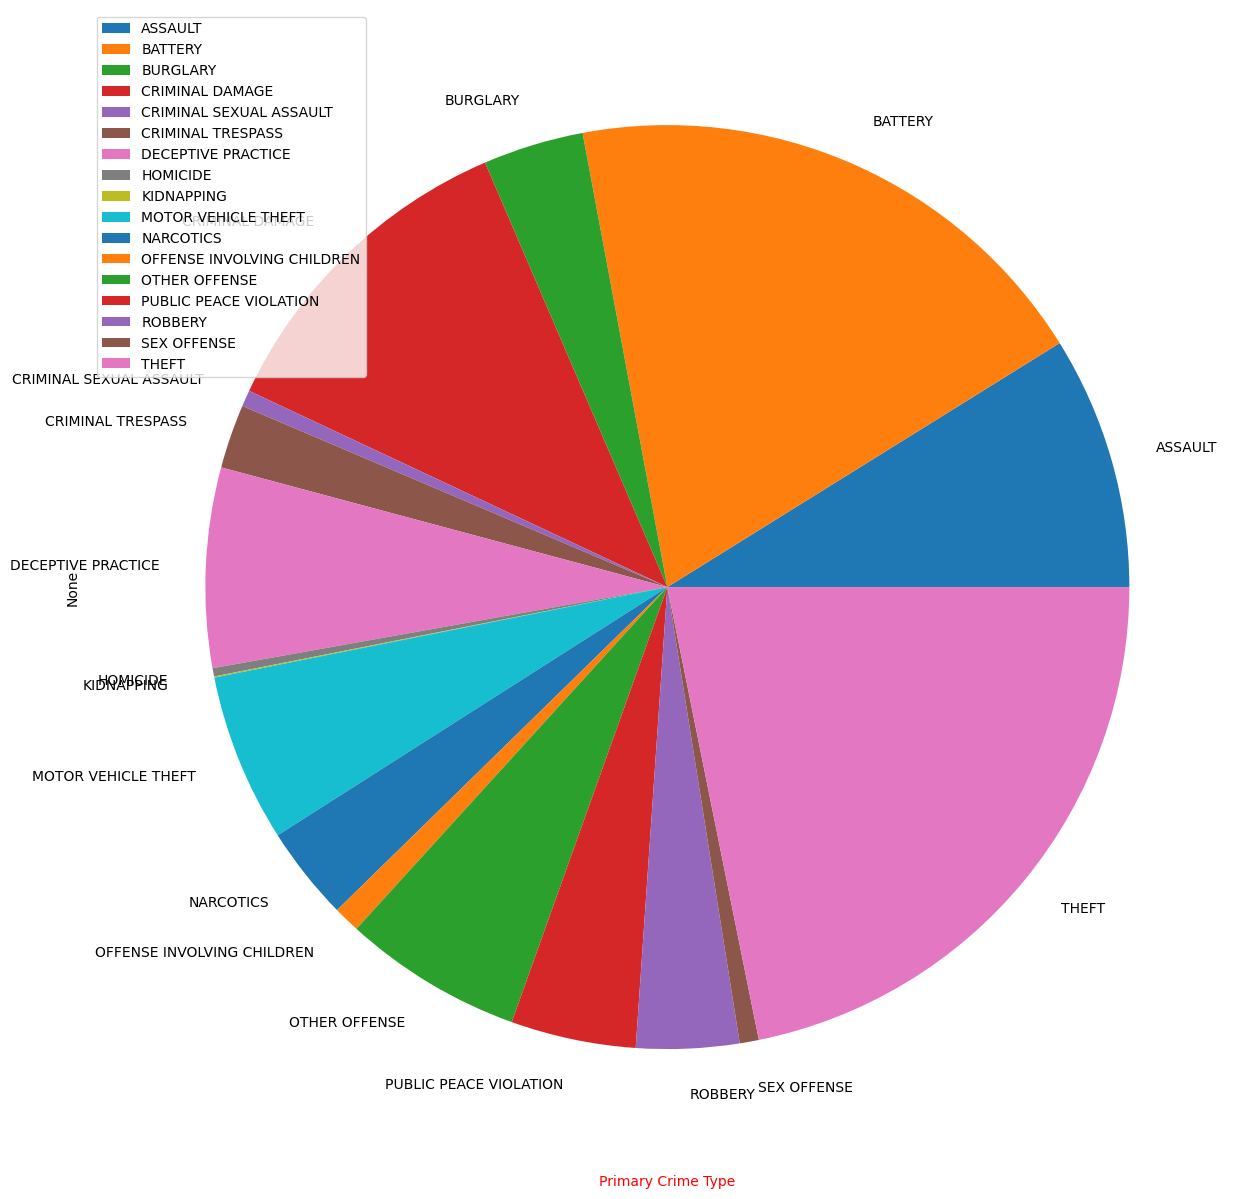

In [33]:
primaryVisualizeDF.plot.pie(figsize = (15,15))
plt.xlabel('Primary Crime Type', fontsize=10, color = 'red')
plt.legend()

# Preprocessing - specific to KNN model

In [34]:
data = data.replace(to_replace='None', value=np.nan).dropna()

**Label Encoding categorical variables**

In [35]:
# create an instance of label encoder for categorical variables
labelEncoder = LabelEncoder()

In [36]:
primaryEncoded = labelEncoder.fit_transform(data['Primary Type'])
primaryEncoded

array([12, 16,  4, ..., 16,  0,  1])

In [37]:
data['Primary Type'] = primaryEncoded

In [38]:
# create an instance of label encoder for categorical variables
labelEncoder2 = LabelEncoder()

In [39]:
locDiscEncoded = labelEncoder2.fit_transform(data['Location Description'])
locDiscEncoded

array([109, 132,  17, ..., 132, 128, 113])

In [40]:
data['Location Description'] = locDiscEncoded

In [41]:
# create an instance of label encoder for categorical variables
labelEncoder3 = LabelEncoder()

In [42]:
blockEncoded = labelEncoder2.fit_transform(data['Location Description'])
blockEncoded

array([109, 132,  17, ..., 132, 128, 113])

In [43]:
data['Block'] = locDiscEncoded

Use PCA to combine features

In [44]:
from sklearn.decomposition import PCA

In [45]:
location = data[['Latitude','Longitude']]
pca = PCA(n_components=1,random_state=123)

In [46]:
loc = pca.fit_transform(location)

In [47]:
data['Location'] = loc

In [48]:
data.head(5)

,Date,Block,Primary Type,Location Description,Arrest,Beat,District,Ward,Community Area,Year,Latitude,Longitude,Day,Month,WeekDay,Location
641835,10/17/2021 05:30:00 PM,109,12,109,False,724,7,16,68,2021,41.777020,-87.652003,2021-10-17,10,1,-0.066502
141953,06/09/2019 04:00:00 AM,132,16,132,False,331,3,5,43,2019,41.767996,-87.574785,2019-06-09,6,1,-0.109534
765476,03/31/2022 12:00:00 PM,17,4,17,False,2534,25,35,20,2022,41.915829,-87.731400,2022-03-31,3,5,0.093216
43508,02/16/2019 08:18:00 PM,17,1,17,False,2413,24,50,2,2019,41.994774,-87.682414,2019-02-16,2,7,0.141395
418553,07/16/2020 01:24:00 PM,128,1,128,True,1424,14,1,24,2020,41.910090,-87.677015,2020-07-16,7,5,0.063457


# Feature selection

Checking importance of features using an ExtraTreesClassifier

In [49]:
# remove date coloum
#data = data.drop("Date", axis='columns')
data = data.drop("Day", axis='columns')
data = data.drop("Date", axis='columns')

In [50]:
#taking a fraction of data
data_sample = data.sample(frac=0.1, random_state=123)

In [51]:

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()

In [52]:

X = data_sample.loc[:, data.columns != 'Primary Type']

model.fit(X,data_sample['Primary Type'])

ExtraTreesClassifier()

In [28]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

[0.06180353 0.06318299 0.02227942 0.07070183 0.0163501  0.04203857
 0.03748195 0.05980583 0.13443623 0.13511013 0.11993583 0.10281868
 0.13405491]


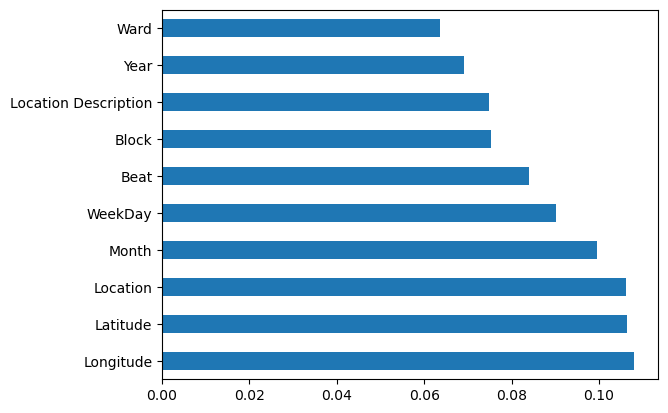

In [53]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
#plot for top 10 features
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Find corelation between data to find dependency between data columns

In [54]:
corelation = data.corr()
corelation

,Block,Primary Type,Location Description,Arrest,Beat,District,Ward,Community Area,Year,Latitude,Longitude,Month,WeekDay,Location
Block,1.000000,0.129315,1.000000,0.057866,0.008732,0.009099,-0.011663,0.031732,-0.032941,-0.054592,-0.012654,0.025943,-0.001106,-0.041088
Primary Type,0.129315,1.000000,0.129315,0.025542,0.044857,0.044804,0.063028,-0.083393,-0.008985,0.091701,0.001228,-0.003878,0.020800,0.074691
Location Description,1.000000,0.129315,1.000000,0.057866,0.008732,0.009099,-0.011663,0.031732,-0.032941,-0.054592,-0.012654,0.025943,-0.001106,-0.041088
Arrest,0.057866,0.025542,0.057866,1.000000,-0.021950,-0.022124,-0.005773,0.013409,-0.103791,-0.016199,-0.034708,-0.034294,0.002133,-0.003424
Beat,0.008732,0.044857,0.008732,-0.021950,1.000000,0.999866,0.649111,-0.487216,0.001951,0.635242,-0.545861,0.006618,0.004477,0.674448
District,0.009099,0.044804,0.009099,-0.022124,0.999866,1.000000,0.650149,-0.487853,0.001928,0.636433,-0.546759,0.006530,0.004561,0.675678
Ward,-0.011663,0.063028,-0.011663,-0.005773,0.649111,0.650149,1.000000,-0.517687,-0.008121,0.663834,-0.463244,0.003590,0.007324,0.674443
Community Area,0.031732,-0.083393,0.031732,0.013409,-0.487216,-0.487853,-0.517687,1.000000,0.000202,-0.772019,0.238460,-0.002790,-0.004992,-0.699295
Year,-0.032941,-0.008985,-0.032941,-0.103791,0.001951,0.001928,-0.008121,0.000202,1.000000,0.000980,0.009427,-0.113299,-0.006147,-0.001869
Latitude,-0.054592,0.091701,-0.054592,-0.016199,0.635242,0.636433,0.663834,-0.772019,0.000980,1.000000,-0.539542,0.002051,0.006261,0.971141


<AxesSubplot:>

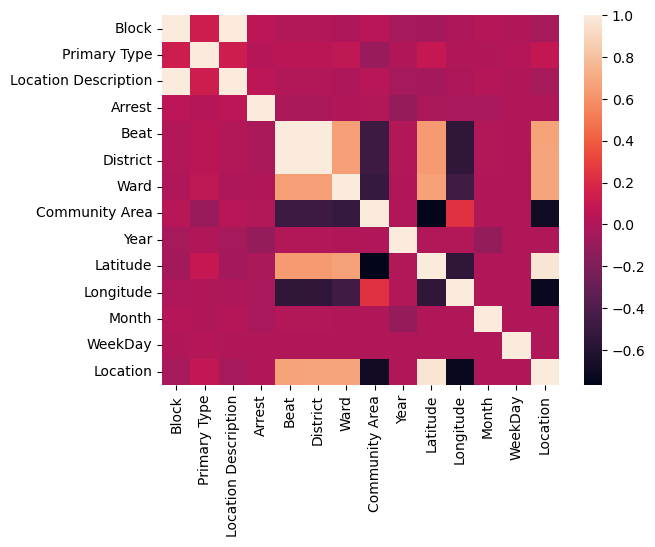

In [31]:
import seaborn as sns
sns.heatmap(corelation)

**Based on the above outputs, we have decided that below selected columns are corelated and best params for our KNN model**

In [55]:
selected_columns = ['Latitude','Longitude','Location Description','Block','WeekDay']
#selected_columns = ['Latitude','Longitude']

# Splitting data in train and test

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[selected_columns], data['Primary Type'], test_size=0.3) # 70% training and 30% test

# Building initial KNN Classifier

**Initially we will build our classifier with 5 neighbours**

In [57]:
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
knn_5 = KNeighborsClassifier(n_neighbors=5) 
knn_5.fit(X_train,y_train)
pred_train = knn_5.predict(X_train)
pred_i = knn_5.predict(X_test)
print('Test accuracy ', metrics.accuracy_score(y_train, pred_train))
print('Accuracy ', metrics.accuracy_score(y_test, pred_i))
print('F1 score ', metrics.f1_score(y_test, pred_i, average = 'weighted'))

/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Test accuracy  0.45477142857142855
Accuracy  0.24633333333333332
F1 score  0.2335222597430528


/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


We will deploy Elbow method to get optimum number of neighbours

In [58]:
error_rate = []

krange = range(10,50,5)
for i in krange:
 
 knn = KNeighborsClassifier(n_neighbors=i, metric='manhattan', weights = 'uniform',n_jobs= -1) # haversine - if only lat long
 knn.fit(X_train,y_train)
 pred_train = knn.predict(X_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != y_test))
 print('Neighbours ',i)
 print('Test accuracy ', metrics.accuracy_score(y_train, pred_train))
 print('Accuracy ', metrics.accuracy_score(y_test, pred_i))
 print('F1 score ', metrics.f1_score(y_test, pred_i, average = 'weighted'))

/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted

Neighbours  10
Test accuracy  0.39065714285714287
Accuracy  0.26853333333333335
F1 score  0.2446178209268109


/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted

Neighbours  15
Test accuracy  0.3670857142857143
Accuracy  0.2778
F1 score  0.24571984609724307


/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted

Neighbours  20
Test accuracy  0.35222857142857145
Accuracy  0.2865333333333333
F1 score  0.24890114748159659


/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted

Neighbours  25
Test accuracy  0.34762857142857145
Accuracy  0.28973333333333334
F1 score  0.24686263976873124


/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted

Neighbours  30
Test accuracy  0.3391142857142857
Accuracy  0.2924
F1 score  0.2468970388097931


/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted

Neighbours  35
Test accuracy  0.33462857142857144
Accuracy  0.2956
F1 score  0.24648778618317105


/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted

Neighbours  40
Test accuracy  0.3308857142857143
Accuracy  0.296
F1 score  0.24319945152075048


/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Neighbours  45
Test accuracy  0.32785714285714285
Accuracy  0.2969333333333333
F1 score  0.24283631901910624


/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Text(0, 0.5, 'Error Rate')

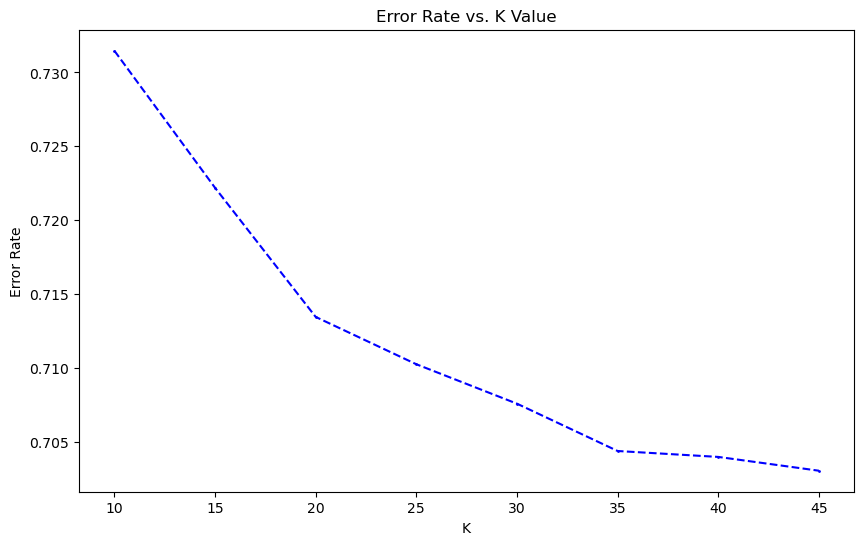

In [59]:
plt.figure(figsize=(10,6))

plt.plot(krange,error_rate, color= 'blue', linestyle= 'dashed', marker= 'o', markerfacecolor='red', markersize=1)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

K = 25, optimum

# Grid Search/ Random Search -KNN

**To find optimal paramteres for KNN Model, we will implement Grid search.**

In [60]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [61]:
KNeighborsClassifier().get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [62]:
grid_params = {
    'weights' : ['uniform', 'distance'],
    'metric' : ['manhattan','jaccard'] #haversine - if only lat long
}

In [63]:
randomSearch = RandomizedSearchCV(
    KNeighborsClassifier(35),
    grid_params,
    verbose = 1,
    cv =3,
    random_state = 123
    )


In [64]:
#takes very long time
rs_results = randomSearch.fit(X_train, y_train)

/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted

In [65]:
rs_results.best_score_

0.2891712461811909

In [66]:
rs_results.best_params_

{'weights': 'uniform', 'metric': 'manhattan'}